# VI vs. BBVI

Following Bishop (chapter 10.1.3), we fit a simple model via variational inference. 

We assume $N$ observations $x$ that are normally distributed with mean $\mu$ and precision $\tau$. We assume that $\mu$ and $\tau$ have conjugate priors, i.e.:

$$\tau \sim \text{Gam}(\tau|a_0, b_0)$$
$$\mu \sim N(\mu_0, (\gamma_0\tau)^{-1})$$

This is a four parameter Gaussian-Gamma conjugate prior distribution.

Consider a factorized posterior for our unknown variables $\mu$, $\tau$:

$$q(\mu, \tau) = q_\mu(\mu)q_\tau(\tau)$$

Here the q's each contain two variational parameters that we need to estimate (four $\lambda$ parameters total).

Bishop shows us how to turn the crank on this model using closed-form VI. As it turns out, the optimal q's are also of the same family. Closed-forms solution are feasible (although this is by no means easy in the general case). 

Let's do this via BBVI instead.

Let's start with the vanilla form of BBVI (eq. 3, [Ranganath et al. (2014)](http://www.cs.columbia.edu/~blei/papers/RanganathGerrishBlei2014.pdf)).

We have that:

![equation 3](./w2-assets/eq3.png)

So now we need only turn the crank:

![algebra page 1](./w2-assets/algebra-page1.jpg)
![algebra page 2](./w2-assets/algebra-page2.jpg)

Note that the variational parameters are denoted with bars, such that $\lambda = \{\bar \mu, \bar \sigma, \bar a, \bar b\}$. Let's try variational updates on these parameters:


In [84]:
# Let's start easy.
%matplotlib inline
import numpy as np
import scipy.special
import matplotlib.pyplot as plt


In [45]:
a0 = 1
b0 = 1
gamma0 = 1
mu0 = 0

N_samples = 100
S = 5

def get_forward_samples(params, N_samples):
    mu0, gamma0, a0, b0 = params
    theta0 = 1/b0
    # Numpy uses an annoying shape/scale parametrization of the gamma distribution.
    tau = np.random.gamma(a0, theta0)
    return (np.random.normal(mu0, 1/(gamma0*tau), N_samples), mu0, tau)

x, true_mu, true_tau = get_forward_samples((mu0, gamma0, a0, b0), N_samples)
print([x.mean(), x.std()])
print([true_mu, 1/true_tau])

[-0.015212947932282448, 0.7329263623634485]
[0, 0.784960358918845]


In [ ]:
def eval_logQ(z, vparams):
    mu, tau = z
    mu_bar, sigma_bar, a_bar, b_bar = vparams
    ll_normal = -1/2*np.log(2*np.pi*sigma_bar**2) - 1/2/sigma_bar**2 * (mu - mu_bar)**2
    ll_gamma = a_bar*np.log(b_bar) - scipy.special.gammaln(a_bar) + (a_bar - 1)*np.log(tau) - b_bar*tau
    return ll_normal + ll_gamma

def sample_q(vparams):
    mu_bar, sigma_bar, a_bar, b_bar = vparams
    return np.random.normal(mu_bar, sigma_bar), np.random.gamma(a_bar, 1/b_bar)

def elbo(x, vparams, N_samples):
    mu_bar, sigma_bar, a_bar, b_bar = vparams
    
    Ls = []
    for i in range(N_samples):
        # Sample from q at random.
        mu, tau = sample_q(vparams)
        log_pxz = -1/2*x.size*np.log(2*np.pi*(gamma0*tau)**-(2)) - ((gamma0*tau)**2/2*(x - mu)**2).sum()
        Ls.append(log_pxz + eval_logQ((mu, tau), vparams))
    
    return np.array(Ls).mean()

mus = np.linspace(-3, 3, 100)
elbos = []
for mu in mus:
    elbos.append(elbo(x, (mu, 1, 1, 1), 10000))

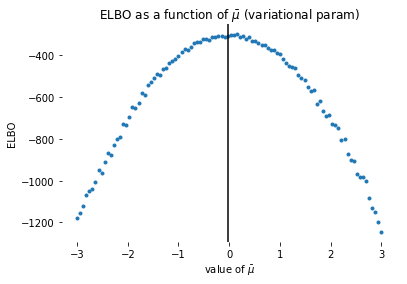

In [147]:
plt.plot(mus, np.array(elbos), '.')
ylim = plt.ylim()
plt.plot([x.mean(), x.mean()], ylim, 'k-')
plt.ylim(ylim)
plt.xlabel('value of $\\bar \\mu$')
plt.ylabel('ELBO')
plt.title('ELBO as a function of $\\bar \\mu$ (variational param)')
plt.box(False)

Our ELBO looks pretty reasonable - it's higher when the value of the variational parameter $\bar \mu$ is close to the empirical mean of the samples (all else being equal). 